In [ ]:
# links
https://brotherbored.com/guest-post-is-the-diplomacy-map-unbalanced/
http://ukdp.diplomatic-pouch.com/pouch/Zine/F2007R/Burton/statistician3.htm


In [5]:
path = "/data/oam_patel/AI_Diplomacy/results/20250227_004209/"

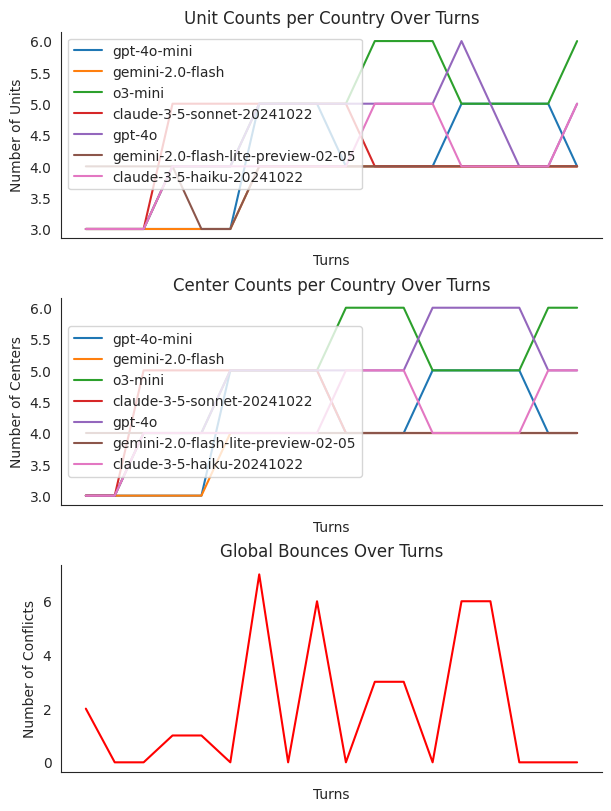

In [6]:
import json
import matplotlib.pyplot as plt
import seaborn as sns

# Set Seaborn style to "white"
sns.set_style("white")

# Load game data (adjust the filename as needed)
with open(path + 'lmvsgame.json', "r") as f:
    game_data = json.load(f)

# Define the list of countries
countries = ["AUSTRIA", "ENGLAND", "FRANCE", "GERMANY", "ITALY", "RUSSIA", "TURKEY"]

# load jsonl
with open(path + 'overview.jsonl', "r") as f:
    overview = [json.loads(line) for line in f]

model_map = overview[1]

# Prepare containers for our statistics over turns
turns = []  # List of phase names
unit_counts = {country: [] for country in countries}
center_counts = {country: [] for country in countries}
conflict_counts = []  # Global statistic per turn

# Iterate over each phase (turn) in the game
for phase in game_data.get("phases", []):
    turn_name = phase.get("name", "Unknown")
    turns.append(turn_name)

    state = phase.get("state", {})

    # Extract unit and center counts per country
    for country in countries:
        units = state.get("units", {}).get(country, [])
        centers = state.get("centers", {}).get(country, [])
        unit_counts[country].append(len(units))
        center_counts[country].append(len(centers))

    # Count conflicts: orders that resulted in a 'bounce'
    results = phase.get("results", {})
    conflicts = sum(1 for outcome in results.values() if "bounce" in outcome)
    conflict_counts.append(conflicts)

# Create subplots for the three statistics
fig, axs = plt.subplots(3, 1, figsize=(6, 8), constrained_layout=True)

# Plot unit counts per country
for country in countries:
    axs[0].plot(turns, unit_counts[country], label=f"{model_map[country]} ({country})")
axs[0].set_title("Unit Counts per Country Over Turns")
axs[0].set_ylabel("Number of Units")
axs[0].set_xlabel("Turns")
axs[0].legend()
sns.despine(ax=axs[0], top=True, right=True)
axs[0].set_xticklabels([])  # Hide x-axis labels

# Plot center counts per country
for country in countries:
    axs[1].plot(turns, center_counts[country], label=f"{model_map[country]} ({country})")
axs[1].set_title("Center Counts per Country Over Turns")
axs[1].set_ylabel("Number of Centers")
axs[1].set_xlabel("Turns")
axs[1].legend()
sns.despine(ax=axs[1], top=True, right=True)
axs[1].set_xticklabels([])  # Hide x-axis labels

# Plot global conflict counts
axs[2].plot(turns, conflict_counts, color="red")
axs[2].set_title("Global Bounces Over Turns")
axs[2].set_ylabel("Number of Conflicts")
axs[2].set_xlabel("Turns")
sns.despine(ax=axs[2], top=True, right=True)
axs[2].set_xticklabels([])  # Hide x-axis labels

plt.show()